# Lab 6

Daniel Alfredo Rayo Roldan

Gerardo Gabriel Pineda Riveiro

https://github.com/Gerax5/DS-lab6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords as nltk_stop
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import warnings
from textblob import TextBlob
import requests
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
import xgboost as xgb
from xgboost import XGBClassifier
import json

warnings.filterwarnings('ignore')

## Cargado de Datos

Para este reporte se trabajó con un junton de datos igual a , que consistian 7613 en mensajes que tenian representaban mensajes positivos o negativos, las frases estaban escritas de un modo que solo usando el contexto y con conocimiento de la semantíca se podía entender si una frase representaba una catastrofe real o solamente figurada.

In [2]:
tweets = []

with open("data/traficogt.txt", "r", encoding="utf-16") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            tweet = json.loads(line)
            tweets.append(tweet)
        except json.JSONDecodeError as e:
            print("⚠️ Error parseando línea:", e)
            print("Línea problemática:", line[:200], "...")
            continue

print(f"Se cargaron {len(tweets)} tweets")


⚠️ Error parseando línea: Expecting ',' delimiter: line 1 column 4314 (char 4313)
Línea problemática: {"id": 1711127305131631071, "id_str": "1711127305131631071", "url": "https://x.com/nquevedoa/status/1711127305131631071", "date": "2023-10-08 21:11:55+00:00", "user": {"id": 204996481, "id_str": "2049 ...
Se cargaron 5604 tweets


In [7]:
print(tweets[0]["quotedTweet"])  # Mostrar las claves del primer tweet para entender su estructura

{'id': 1834029142565658846, 'id_str': '1834029142565658846', 'url': 'https://x.com/monymmorales/status/1834029142565658846', 'date': '2024-09-12 00:39:56+00:00', 'user': {'id': 976875408, 'id_str': '976875408', 'url': 'https://x.com/monymmorales', 'username': 'monymmorales', 'displayname': 'Mony', 'rawDescription': 'Iglesia y estado son asunto separado.\nCatólica \n#SuMenteMeOlvidó, pero su corazón siempre me recordó.  \n#Guatemala \n#DonaciónDeÓrganos\n\n#GraciasPorEstar', 'created': '2012-11-28 20:16:36+00:00', 'followersCount': 5502, 'friendsCount': 4887, 'statusesCount': 180436, 'favouritesCount': 274770, 'listedCount': 24, 'mediaCount': 16644, 'location': 'Guatemala #Frijolandia ', 'profileImageUrl': 'https://pbs.twimg.com/profile_images/1810923178228609024/mXrBHHnl_normal.jpg', 'profileBannerUrl': 'https://pbs.twimg.com/profile_banners/976875408/1706033530', 'protected': None, 'verified': False, 'blue': False, 'blueType': None, 'descriptionLinks': [], 'pinnedIds': [17948030109354

In [4]:
first_rt = None
for i, tweet in enumerate(tweets):
    if tweet.get("retweetedTweet") is not None:
        first_rt = (i, tweet)
        break

if first_rt:
    idx, tw = first_rt
    print(f"El primer retweet está en tweets[{idx}]")
    print("ID:", tw["id"])
    print("Usuario:", tw["user"]["username"])
    print("Texto:", tw["rawContent"])
else:
    print("No se encontró ningún retweet")


No se encontró ningún retweet


In [5]:
first_rt = None
for i, tweet in enumerate(tweets):
    if len(tweet.get("mentionedUsers", [])) > 0:
        first_rt = (i, tweet)
        break

if first_rt:
    idx, tw = first_rt
    print(f"El primer retweet está en tweets[{idx}]")
    print("ID:", tw["id"])
    print("Usuario:", tw["user"]["username"])
    print("Texto:", tw["rawContent"])
else:
    print("No se encontró ningún retweet")


El primer retweet está en tweets[1]
ID: 1834029142565658846
Usuario: monymmorales
Texto: La corrupción de la @CC_Guatemala
es descarada, falsificación de documentos y obligaron a extenderles DPI.
https://t.co/0J24ZCXJ2c


In [8]:
first_rt = None
for i, tweet in enumerate(tweets):
    if tweet.get("quotedTweet") is not None:
        first_rt = (i, tweet)
        break

if first_rt:
    idx, tw = first_rt
    print(f"El primer retweet está en tweets[{idx}]")
    print("ID:", tw["id"])
    print("Usuario:", tw["user"]["username"])
    print("Texto:", tw["rawContent"])
else:
    print("No se encontró ningún retweet")


El primer retweet está en tweets[0]
ID: 1834236045598056867
Usuario: traficogt
Texto: Es comprensible la resolución... El ruso sabe de engrasar maquinaria.


In [ ]:
edges = []

for t in tweets:
    source = t["user"]["id_str"]
    tweet_id = t["id_str"]

    if t.get("quotedTweet"):
        target = t["quotedTweet"]["user"]["id_str"]
        edges.append({
            "source": source,
            "target": target,
            "relation_type": "quote",
            "tweet_id": tweet_id
        })

    if t.get("mentionedUsers"):
        for u in t["mentionedUsers"]:
            target = u["id_str"]
            edges.append({
                "source": source,
                "target": target,
                "relation_type": "mentioned",
                "tweet_id": tweet_id
            })

df_edges = pd.DataFrame(edges)

print(df_edges.head())

df_edges.to_csv("tweet_relations.csv", index=False)


                source               target relation_type             tweet_id
0             93938886            976875408         quote  1834236045598056867
1            976875408   783345301256073216     mentioned  1834029142565658846
2  1730828822029750272            130315077     mentioned  1834039491826180424
3  1730828822029750272             89030065     mentioned  1834039491826180424
4  1730828822029750272  1744119413383598080     mentioned  1834039491826180424


                source              target relation_type  weight
0           1000059482            93938886     mentioned       1
1  1000197925958553600            93938886     mentioned       1
2            100256200           372126670     mentioned       1
3            100256200            93938886     mentioned       1
4            100256200  991834302781456384     mentioned       1


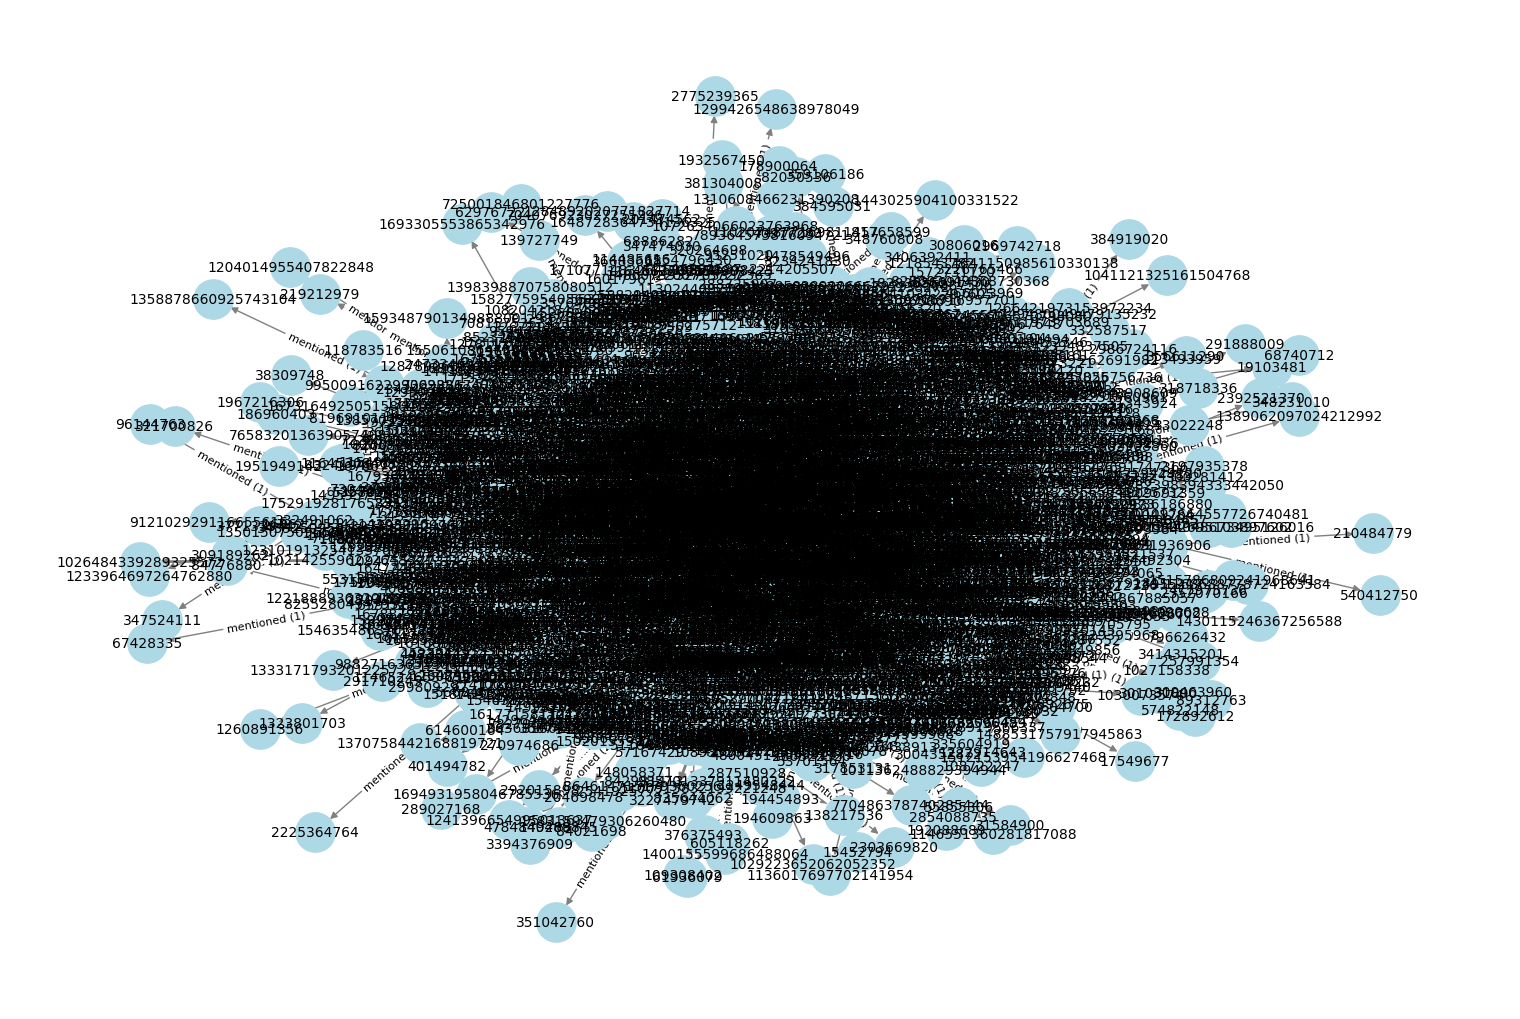

In [ ]:
df_unique_edges = df_edges.drop_duplicates(
    subset=["source", "target", "relation_type"]
)

print(df_unique_edges)


                source              target relation_type  weight
0           1000059482            93938886     mentioned       1
1  1000197925958553600            93938886     mentioned       1
2            100256200           372126670     mentioned       1
3            100256200            93938886     mentioned       1
4            100256200  991834302781456384     mentioned       1


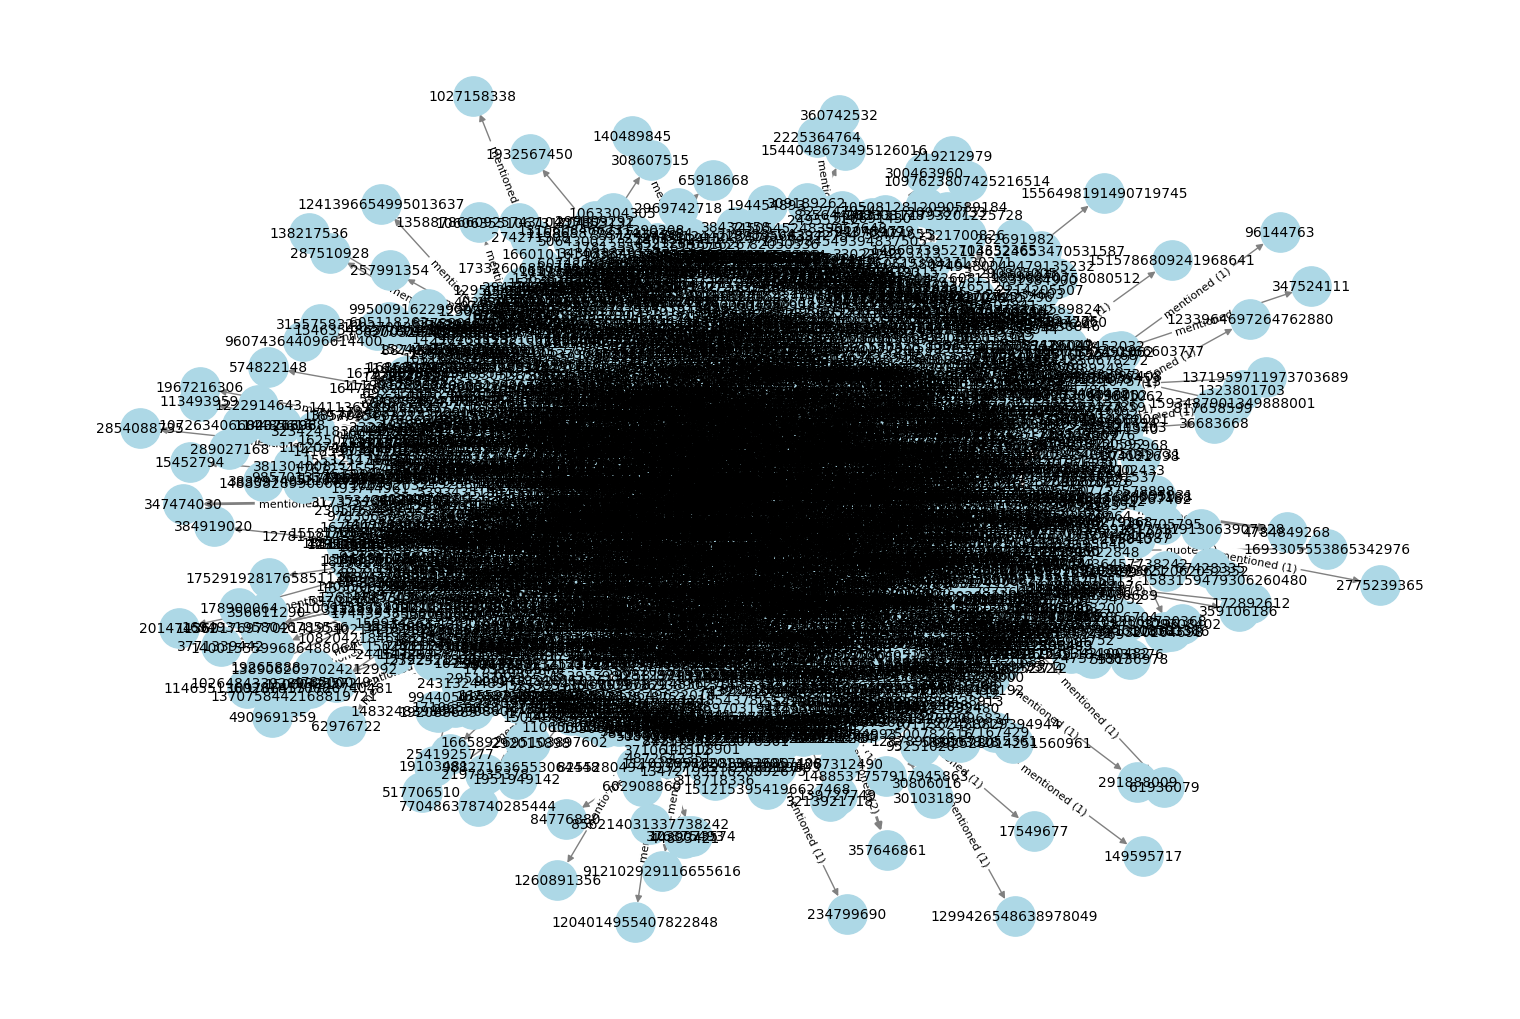

In [ ]:
import matplotlib.pyplot as plt

df_edges_weighted = (
    df_edges
    .groupby(["source", "target", "relation_type"])
    .size()
    .reset_index(name="weight")   
)

print(df_edges_weighted.head())

import networkx as nx

G = nx.DiGraph()

for _, row in df_edges_weighted.iterrows():
    G.add_edge(
        row["source"],
        row["target"],
        relation_type=row["relation_type"],
        weight=row["weight"]
    )


plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.7)

edges = G.edges(data=True)
weights = [d["weight"] for (_, _, d) in edges]

nx.draw(
    G, pos,
    with_labels=True,
    node_size=800,
    node_color="lightblue",
    font_size=10,
    edge_color="gray",
    width=[w for w in weights]  
)

edge_labels = { (u,v): f"{d['relation_type']} ({d['weight']})"
               for u,v,d in G.edges(data=True) }
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.show()


In [17]:
# Filtrar edges con peso >= 2
df_filtered = df_edges_weighted[df_edges_weighted["weight"] >= 2]

print("Aristas antes:", len(df_edges_weighted))
print("Aristas después:", len(df_filtered))


Aristas antes: 7544
Aristas después: 1340


In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(
    df_edges_weighted,
    source="source",
    target="target",
    edge_attr=["relation_type", "weight"],
    create_using=nx.DiGraph()
)

degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:20]  

G_sub = G.subgraph(top_nodes).copy()


In [13]:
df_edges.shape, df_unique_edges.shape

((11540, 4), (7544, 4))

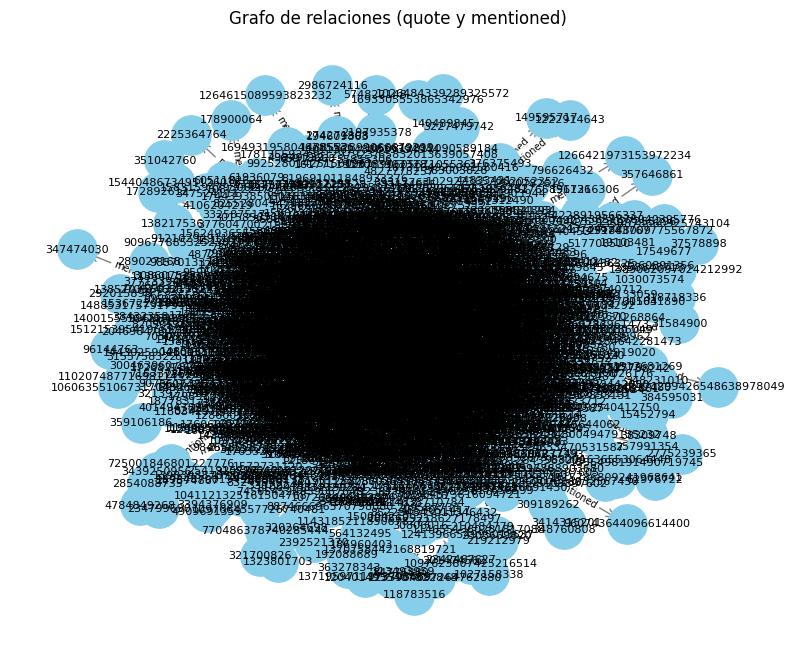

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in df_edges.iterrows():
    G.add_edge(
        row["source"], 
        row["target"], 
        relation=row["relation_type"], 
        tweet_id=row["tweet_id"]
    )

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=800, node_color="skyblue")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Grafo de relaciones (quote y mentioned)")
plt.axis("off")
plt.show()


ValueError: 'transparent' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

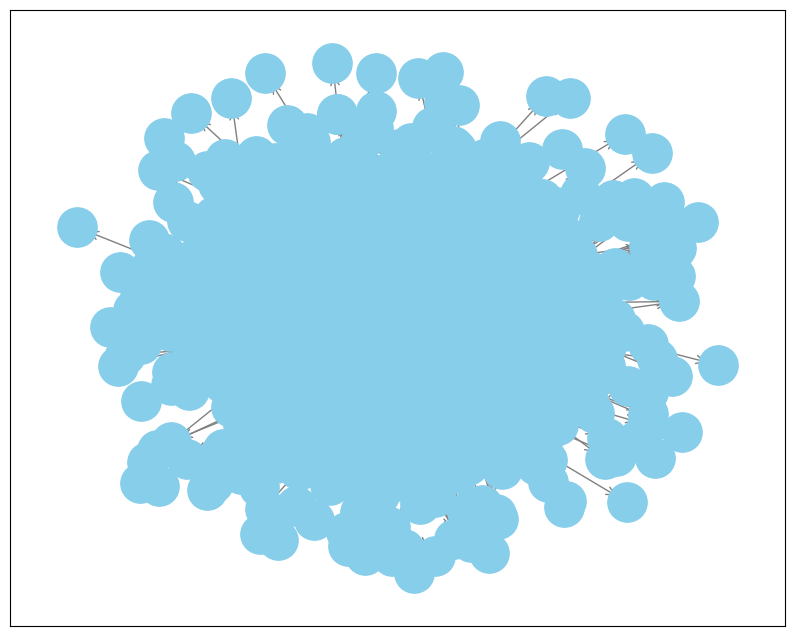

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in df_unique_edges.iterrows():
    G.add_edge(
        row["source"], 
        row["target"], 
        relation=row["relation_type"], 
    )

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=800, node_color="skyblue")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Grafo de relaciones (quote y mentioned)")
plt.axis("off")
plt.show()


### Para llevarnos

# user
* Username
* id_str
* followersCount
* friendsCount
* mediaCount
* verified
# rawContent
# likeCount
# quoteCount
# hashtags
# cashtags
# mentionedUsers
# viewCount
# retweetedTweet
# quotedTweet -> id


---
# quotedTweet
# user
* Username
* id_str
* followersCount
* friendsCount
* mediaCount
* verified
# rawContent
# likeCount
# quoteCount
# hashtags
# cashtags
# mentionedUsers
# viewCount
# retweetedTweet
# quotedTweet